In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats


set_logger()

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

path = "DWSNets/dataset/mnist_splits.json" # data_path = 
statistics_path = "DWSNets/dataset/statistics.pth" # data_path = 
normalize = True
augmentation = True

batch_size = 32
num_workers = 4

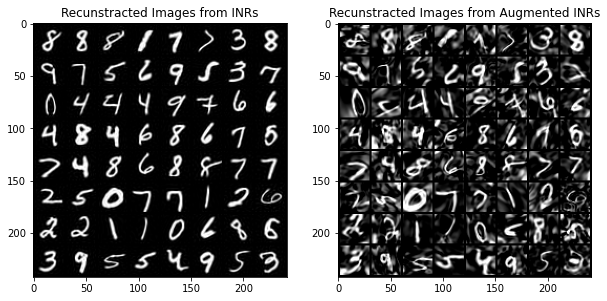

In [3]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt

# Create non-augmented INRImage Dataset
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Create augmented INRImage Dataset
dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)


batch = next(iter(loader))
batch_aug = next(iter(loader_aug))


fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()


In [4]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    ) # create dataset for the training set (seen in training)

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the validation set (seen in training)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the test set (not seen in training)


# Now make torch dataloaders for those datasets
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

# Keeping track of stuff
logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

# Try running the DWSNet on augmented INRs like displayed and not the raw ones like it does stock

/home/biggs.s/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-11-25 14:43:08,336 - root - INFO - train size 55000, val size 5000, test size 10000


In [5]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU
from nn.layers.base import BaseLayer, GeneralSetLayer
from nn.models import DWSModel

import matplotlib.pyplot as plt
import random
import numpy as np


import argparse
import pickle
from collections import defaultdict
from pathlib import Path
from typing import NamedTuple
import numpy.ma as ma

import jax
import jax.numpy as jnp
# from flax.serialization import from_bytes
from jax import random, tree_map
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

import wandb

# Prepare a random number generator
seed = 0
rng = np.random.default_rng(seed)

def rngmix(seed):
    return np.random.default_rng(
                [rng._bit_generator._seed_seq.entropy, hash(seed)])

In [14]:
from typing import NamedTuple, Tuple, Union

def tuples_to_tensors(point):
    """
    Convert INR tuple to weights and biases tensors
    """
    weights_tuple, biases_tuple = point.weights, point.biases
    permutations = defaultdict(list)
    for i,(layer_weights,layer_biases) in enumerate(zip(weights_tuple,biases_tuple)): 
        permutations["layer_"+str(i+1)+"_weights"] = np.array(layer_weights)
        permutations["layer_"+str(i+1)+"_biases"] = np.array(layer_biases)
    return permutations

def tensors_to_tuples(permutations):
    """
    Convert a dictionary of weights and biases tensors back to a tuple of tuples
    """
    weights = []
    biases = []

    # Extract layers from the dictionary
    num_layers = len(permutations) // 2  # Assumes equal weights and biases entries

    for i in range(1, num_layers + 1):
        # Retrieve weights and biases for the layer
        weights_key = f"layer_{i}_weights"
        biases_key = f"layer_{i}_biases"

        weights.append(torch.tensor(permutations[weights_key]))
        biases.append(torch.tensor(permutations[biases_key]))

    return (tuple(weights), tuple(biases))

import numpy.ma as ma
from scipy.optimize import linear_sum_assignment

def apply_permutations(ps, perm, params_b):
    """
    Apply the calculated permutations to params_b.
    
    Args:
        ps: The permutation structure (providing perm_to_axes).
        perm: The computed permutations (output of weight_matching).
        params_b: The parameters to permute.
    
    Returns:
        A new dictionary with permuted `params_b`.
    """
    permuted_params_b = defaultdict(list)

    for param_name, weights in params_b.items():
        permuted_weights = weights.copy()

        for p, axes in ps.perm_to_axes.items():
            for wk, axis in axes:
                if wk == param_name:
                    permuted_weights = np.take(permuted_weights, perm[p], axis=axis)

        # Store the permuted weights
        permuted_params_b[param_name] = permuted_weights

    return permuted_params_b


def weight_matching_layers(rng, ps, params_a, params_b, max_iter=100, init_perm=None, silent=False):
    """
    Find a permutation of `params_b` to make them match `params_a`.

    Args:
        rng: Random number generator.
        ps: A structure that provides permutation mapping (perm_to_axes).
        params_a: Reference parameters (e.g., from a pre-trained model).
        params_b: Parameters to be permuted (e.g., from another model).
        max_iter: Maximum number of iterations for optimization.
        init_perm: Initial permutation, if any.
        silent: If True, suppress logging.
    Returns:
        A dictionary containing the optimal permutations for each layer.
    """
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
    
    # Initialize permutations
    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    perm_names = list(perm.keys())

    for iteration in range(max_iter):
        progress = False
        # Shuffle layer processing order for robustness
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            A = np.zeros((n, n))

            # Accumulate similarity matrices across all axes for layer `p`
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                if 'bn' in wk or 'downsample.1' in wk:  # Skip normalization layers
                    w_b = w_a.copy()
                else:
                    # Get permuted version of params_b for current axis
                    w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                # Reshape and compute contribution to similarity matrix
                w_a = np.moveaxis(w_a, axis, 0).reshape((n, -1))
                w_b = np.moveaxis(w_b, axis, 0).reshape((n, -1))
                A += w_a @ w_b.T

            # Solve assignment problem to find the best permutation
            ri, ci = linear_sum_assignment(A, maximize=True)
            assert (ri == np.arange(len(ri))).all()  # Sanity check

            # Compute alignment scores before and after permutation
            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
            if not silent:
                print(f"Iteration {iteration} - Layer {p}: Score improvement {newL - oldL:.6f}")

            # Update permutation if there is an improvement
            progress = progress or newL > oldL + 1e-12
            perm[p] = np.array(ci)

        # Exit if no improvement is observed
        if not progress:
            break

    return perm

# Define a mock permutation structure
class PermStructure:
    def __init__(self, perm_to_axes):
        self.perm_to_axes = perm_to_axes

# Define `get_permuted_param` function
def get_permuted_param(ps, perm, param_name, params, except_axis):
    """
    Get permuted parameter based on current permutations.
    """
    w = params[param_name]
    for p, axes in ps.perm_to_axes.items():
        for wk, axis in axes:
            if wk == param_name and axis != except_axis:
                w = np.take(w, perm[p], axis=axis)
    return w

class Batch(NamedTuple):
    weights: Tuple
    biases: Tuple
    label: Union[torch.Tensor, int]

    def _assert_same_len(self):
        assert len(set([len(t) for t in self])) == 1

    def as_dict(self):
        return self._asdict()

    def to(self, device):
        """move batch to device"""
        return self.__class__(
            weights=tuple(w.to(device) for w in self.weights),
            biases=tuple(w.to(device) for w in self.biases),
            label=self.label.to(device),
        )

    def __len__(self):
        return len(self.weights[0])


class RebasinedINRDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset,
        ps,
        group_by_labels = False,
        n_samples = 20,
        max_iter = 5,
        focus_class = 1,
    ):

        self.dataset = dataset # The reference INRDataset before applying GitRebasin
        self.ps = ps
        
        # Needs updating
        if group_by_labels == False: 
            print(f"This isn't working right now!")
            data_points = []
            for data in dataset:
                data_points.append(data)
                if len(data_points) == n_samples:
                    break

        # This rebasins by class. 
        classes = 10
        c = 0
        if group_by_labels == True: 
            labels = []
            for focus_class in range(classes):
                data_points = []
                for data in dataset:
                    if data.label == focus_class:
                        data_points.append(data)
                        labels.append(data.label)
                        
                    if len(data_points) == n_samples:
                        print(f"n_samples reached")
                        break

                                    
                ref_point = data_points[0]
                data_points = data_points[1:]
                ref_data_param = tuples_to_tensors(ref_point)
                rng = np.random.default_rng(seed=42) 
                
                permuted_params = []
                data_point_params = []
                for data in data_points:
                    data_params = tuples_to_tensors(data)
                    perm = weight_matching_layers(rng, ps, ref_data_param, data_params, max_iter = max_iter, silent = True) # Silence! 
                    permuted_param = apply_permutations(ps, perm, data_params)
                    permuted_params.append(permuted_param)
                    data_point_params.append(data_params)

  
        
        self.data_points = data_points
        self.permuted_points = permuted_params
        self.data_params = data_point_params
        self.labels = labels

    def __len__(self):
        return len(self.permuted_points)
    
    def __getitem__(self, item):
        points = self.permuted_points[item]
        weights, biases = tensors_to_tuples(points)
#         label = int(self.data_points[item].label)
        label = int(self.labels[item])

        return Batch(weights = weights, biases = biases, label = label)


In [15]:
# Define permutation mapping (example for 3 layers)
perm_to_axes = {
    "layer_1": [("layer_1_weights", 0)],
    "layer_2": [("layer_2_weights", 0)],
    "layer_3": [("layer_3_weights", 0)],
}

# Instantiate permutation structure
ps = PermStructure(perm_to_axes)

test = RebasinedINRDataset(train_set, ps, n_samples = 60000, max_iter = 10, group_by_labels = True) # yay! 

1x1000 Points Computed
2x1000 Points Computed
3x1000 Points Computed
4x1000 Points Computed
5x1000 Points Computed
6x1000 Points Computed
7x1000 Points Computed
8x1000 Points Computed
9x1000 Points Computed
10x1000 Points Computed
11x1000 Points Computed
12x1000 Points Computed
13x1000 Points Computed
14x1000 Points Computed
15x1000 Points Computed
16x1000 Points Computed
17x1000 Points Computed
18x1000 Points Computed
19x1000 Points Computed
20x1000 Points Computed
21x1000 Points Computed
22x1000 Points Computed
23x1000 Points Computed
24x1000 Points Computed
25x1000 Points Computed
26x1000 Points Computed
27x1000 Points Computed
28x1000 Points Computed
29x1000 Points Computed
30x1000 Points Computed
31x1000 Points Computed
32x1000 Points Computed
33x1000 Points Computed
34x1000 Points Computed
35x1000 Points Computed
36x1000 Points Computed
37x1000 Points Computed
38x1000 Points Computed
39x1000 Points Computed
40x1000 Points Computed
41x1000 Points Computed
42x1000 Points Computed
4

In [35]:
test.__len__(), test.__getitem__(5433).label

(5442, 1)

In [22]:
num_workers = 4
batch_size = 32

INR_test_loader = torch.utils.data.DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

In [23]:
point = test.__getitem__(0)
list(point.as_dict().keys())

[w.shape for w in point.weights], [b.shape for b in point.biases]

([torch.Size([2, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 1, 1])],
 [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([1, 1])])

In [24]:
# shapes to initialize the DWSNet
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

# The DWSModelForClassification class must already be in their GitHub
model = DWSModelForClassification(
    weight_shapes = weight_shapes, # Dont change these - they make sense 
    bias_shapes = bias_shapes,
    input_features = 1, # 1 because the network is looking for 1 feature per input?
    hidden_dim = 16, # 32
    n_hidden = 2, # 4
    input_dim_downsample = None, # To test Downsample DWS stuff 
    bn = True, # True - Maybe turn them off? 
).to(device)

In [25]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1) # The softmax by proxy 'hard'max XD  
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())

    model.train()
    avg_loss = loss / total
    avg_acc = correct / total

    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

import random
def reset_seed():
    np.random.seed( 999 )
    random.seed( 999 )
    torch.manual_seed( 999 )

# Removed: 
# - Test set stats per epoch
def Train(model, train_loader, epochs):
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)
    
    epoch_iter = trange(epochs)
    criterion = nn.CrossEntropyLoss()
    test_acc = -1
    
    losses = []
    sums = []
    j = 0
    
    for epoch in epoch_iter:
        for i, batch in enumerate(train_loader):
            j = j + 1
            
            model.train()
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            

# To-Do: Make some working logic here so I don't have to manually fix it
#             out, x = model(inputs)
            out = model(inputs)
                        
            
            loss = criterion(out, batch.label)
            loss.backward()
            optimizer.step()
            
            losses.append( loss.item() )
            epoch_iter.set_description(f"[{epoch} {i+1}], train loss: {loss.item():.3f}")
            
#         if (epoch+1)%3 == 0: 
#             print(x)
            
    plt.plot( np.linspace(0, j, j, endpoint = True), losses, color = 'r')
    

[4 171], train loss: 0.000: 100%|██████████| 5/5 [03:59<00:00, 47.91s/it]


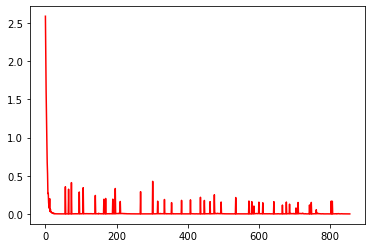

In [26]:
Train(model, INR_test_loader, 5)

(array([5433.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

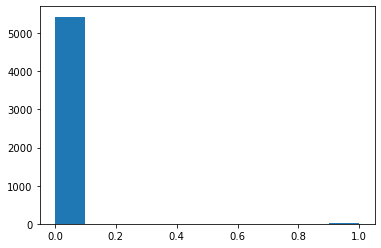

In [27]:
tabs = []
for i in range(test.__len__()):
    tabs.append(test.__getitem__(i).label)

plt.hist(tabs)

# Let's try this for an autoencoder

In [36]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU
from nn.layers.base import BaseLayer, GeneralSetLayer
from nn.models import DWSModel

import matplotlib.pyplot as plt
import random
import numpy as np

In [37]:
class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        dropout_rate=0.0,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=input_features,
            bias=bias,
        )
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )
        
    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        weights = tuple(nn.BatchNorm2d(w.shape[1]).to(device)(w) for w in weights)
        biases = tuple(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1) for b in biases)
        return weights, biases
    
    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], self.downsample_dim)
        biases = self.downsample_input_biases(x[1], self.downsample_dim)
        weights, biases = self.batchNormLayer( weights, biases)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features = d0,
            out_features = downsample_dim,
            reduction = "attn",
            bias=self.bias,
            n_fc_layers = self.n_fc_layers,
            num_heads = self.num_heads,
            set_layer = "ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + residual)

class BiasResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.relu(x + residual)

import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # For Weight Reconstruction
        self.deconv_weight_1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_21 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_22 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_3 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 24, kernel_size=(1, 1)),
            ResidualBlock(24),
            nn.ConvTranspose2d(24, 32, kernel_size=(1, 1)),
        )

        # For Bias Reconstruction
        self.fc_bias_1 = nn.Sequential(
            nn.Linear(8, 16),
            BiasResidualBlock(16),
            nn.Linear(16, 24),
            BiasResidualBlock(24),
            nn.Linear(24, 32),
        )
        self.fc_bias_2 = nn.Sequential(
            nn.Linear(8, 16),
            BiasResidualBlock(16),
            nn.Linear(16, 24),
            BiasResidualBlock(24),
            nn.Linear(24, 32),
        )
        self.fc_bias_3 = nn.Sequential(
            nn.Linear(1, 1),
            BiasResidualBlock(1),
            nn.Linear(1, 1),
        )

    def forward(self, x):
        # Decode weight tensors
        weight_space = x[0]
        bias_space = x[1]
        new_weight_space = []
        new_weight_space.append(self.deconv_weight_1(weight_space[0].permute(0,2,1,3)).permute(0,2,1,3))
        weight2_intermediate = self.deconv_weight_21(weight_space[1])
        new_weight_space.append(self.deconv_weight_22(weight2_intermediate.permute(0,2,1,3)).permute(0,2,1,3))
        new_weight_space.append(self.deconv_weight_3(weight_space[2]))

        new_bias_space = []
        # Decode bias tensors
        new_bias_space.append(self.fc_bias_1(bias_space[0].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_2(bias_space[1].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_3(bias_space[2].squeeze(-1)).view(-1, 1, 1))
        
        return (tuple(new_weight_space), tuple(new_bias_space))

In [39]:
# Our AutoEncoder using DWSModel
class AssembleEncoderBlocks(nn.Module):
    def __init__(self,
#             input_features,
#             weight_shapes,
#             bias_shapes,
            first_hidden_dim = 32,
            target_downsample_dim = 8,
            n_hidden = 1,
            reduction = "max",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        

        weight_shapes_list = []
        bias_shapes_list = []
        
        grade = int(first_hidden_dim/target_downsample_dim )
        assert grade > 0, "grade must be at least 1."
        for i in range( grade ):
            layer_weight_dim = (grade - i)*target_downsample_dim
            weight_shapes_list.append((torch.Size([2, layer_weight_dim]), 
                                       torch.Size([layer_weight_dim,layer_weight_dim]), 
                                       torch.Size([layer_weight_dim, 1])
                                      )
                                     )
        for j in range( grade ):
            layer_bias_dim = (grade - j)*target_downsample_dim
            bias_shapes_list.append((torch.Size([layer_bias_dim]),
                                     torch.Size([layer_bias_dim]),
                                     torch.Size([1])
                                    )
                                   )

            
        self.encoder_layers = nn.ModuleList()
        for k in range( grade ):
            self.encoder_layers.append(DWSEncoder(weight_shapes = weight_shapes_list[k],
                                                  bias_shapes = bias_shapes_list[k],
                                                  input_features = 1, 
                                                  hidden_dims = (grade - k)*target_downsample_dim, # use this to speed up shapes?
                                                  downsample_dim = max((grade - k-1), 1)*target_downsample_dim,
                                                  n_hidden = n_hidden,
                                                  reduction = reduction,
                                                  bn = False,
                                                 )
                                       )
        self.decoder = Decoder().to(device)
            

        
        
    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):

        for layer in self.encoder_layers:
            x = layer(x)
            
        out = self.decoder(x)
        return out

# Training:

In [40]:
# Custom loss function for tuples of tensors because our AutoEncoder gets tensors as output (not sure if this is the correct approach)
class ModTupleLoss(nn.Module):
    def __init__(self):
        super(ModTupleLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.L1_loss = nn.L1Loss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        total_loss = sum( (self.mse_loss(w1, w2)+self.L1_loss(w1, w2)) for w1, w2 in zip(weights1, weights2) ) + \
             sum( (self.mse_loss(b1, b2)+self.L1_loss(b1, b2)) for b1, b2 in zip(biases1, biases2) )

        return total_loss
    
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        total_loss = sum( (self.mse_loss(w1, w2) ) for w1, w2 in zip(weights1, weights2) ) + \
             sum( (self.mse_loss(b1, b2) ) for b1, b2 in zip(biases1, biases2) )

        return total_loss
        

In [55]:
import logging
import torch
from tqdm import trange

# Custom Learning Rate Adjustment Function
def adjust_learning_rate(optimizer, epoch, initial_lr, lr_factor=0.1):
    """Reduces learning rate after 25 epochs, then after every 50 epochs."""
    if epoch == 25 or (epoch > 25 and (epoch - 25) % 50 == 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_factor
        print(f"Reduced learning rate at epoch {epoch} to {param_group['lr']}")
        
def train_model(model, train_loader, num_epochs = 1):
    learning_rate = 1e-3
    num_epochs = 1
    epoch_iter = trange(num_epochs)
    criterion = TupleLoss() 
    epoch_loss = -1
    losses = []
    j = 0
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        j = j+1
        
        for i, batch in enumerate(train_loader):
            model.train() 
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            
            out = model(inputs)
            loss = criterion(out, inputs)
            loss.backward()  
            optimizer.step() 

            total_loss += loss.item()
            counter += 1
            losses.append(loss.item())
            
            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.3f}, epoch loss: {epoch_loss:.3f}"
            )

        losses.append(loss.item())
        epoch_loss = total_loss / counter
        adjust_learning_rate(optimizer, epoch, learning_rate)
#         plt.plot( np.linspace(0, num_epochs, num_epochs, endpoint = True), losses, color = 'r')


    print("Training complete!")


In [56]:
model = AssembleEncoderBlocks(
            first_hidden_dim = 32,
            target_downsample_dim = 8,
            n_hidden = 1,
            reduction = "max",
            input_dim_downsample=None,
            bn = False, # doesnt matter bc bn=true is baked into the forward pass in encoder
).to(device)

train_model(model, INR_test_loader, num_epochs = 10)

  0%|          | 0/1 [00:00<?, ?it/s]/home/biggs.s/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[0 171], train loss: 6.837, epoch loss: -1.000: 100%|██████████| 1/1 [01:22<00:00, 82.42s/it]

Training complete!
